In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score

In [3]:
# Step 1: Generate Random Data
def generate_data(samples_per_class=100):
    np.random.seed(42)
    class1 = np.random.randn(samples_per_class, 2) + np.array([3, 3])  # Shifted from [2, 2]
    class2 = np.random.randn(samples_per_class, 2) + np.array([8, 8])  # Shifted from [6, 6]
    class3 = np.random.randn(samples_per_class, 2) + np.array([13, 3]) # Shifted from [10, 2]
    X = np.vstack([class1, class2, class3])
    y = np.array([0] * samples_per_class + [1] * samples_per_class + [2] * samples_per_class)
    return X, y


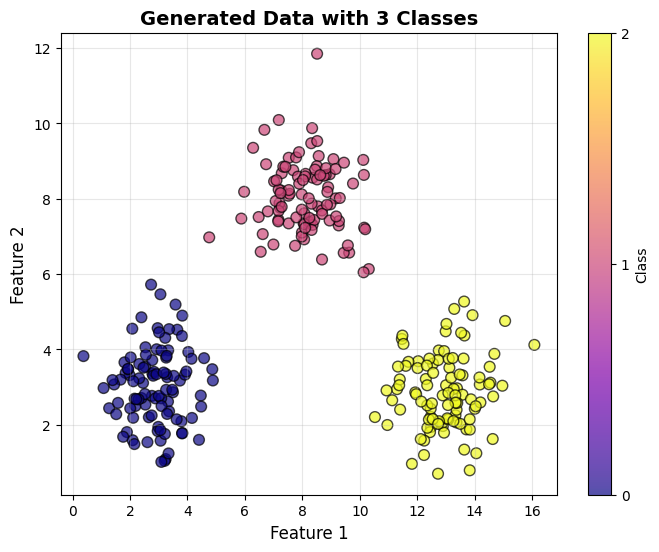

In [4]:
# Generate and visualize the data
X, y = generate_data()

plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="plasma", s=60, edgecolors="k", alpha=0.7)
plt.title("Generated Data with 3 Classes", fontsize=14, fontweight='bold')
plt.xlabel("Feature 1", fontsize=12)
plt.ylabel("Feature 2", fontsize=12)
plt.grid(alpha=0.3)
plt.colorbar(label="Class", ticks=[0, 1, 2])
plt.show()


In [5]:
# Step 2: Prepare Data (Preprocessing)
encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(y.reshape(-1, 1))

X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Train set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Train set: 180 samples
Validation set: 60 samples
Test set: 60 samples


In [6]:
# Step 3: Define the Neural Network
class NeuralNet:
    def __init__(self, input_size, hidden_layer1_neurons, hidden_layer2_neurons,
                 hidden_layer3_neurons, output_size, learning_rate=0.01):
        self.W1 = np.random.randn(input_size, hidden_layer1_neurons)
        self.W2 = np.random.randn(hidden_layer1_neurons, hidden_layer2_neurons)
        self.W3 = np.random.randn(hidden_layer2_neurons, hidden_layer3_neurons)
        self.W4 = np.random.randn(hidden_layer3_neurons, output_size)
        self.lr = learning_rate

    def sigmoid(self, x, derivative=False):
        if derivative:
            return x * (1 - x)
        return 1 / (1 + np.exp(-x))

    def feed_forward(self, x):
        self.hidden1_input = np.dot(x, self.W1)
        self.hidden1_output = self.sigmoid(self.hidden1_input)

        self.hidden2_input = np.dot(self.hidden1_output, self.W2)
        self.hidden2_output = self.sigmoid(self.hidden2_input)

        self.hidden3_input = np.dot(self.hidden2_output, self.W3)
        self.hidden3_output = self.sigmoid(self.hidden3_input)

        self.output_input = np.dot(self.hidden3_output, self.W4)
        self.output = self.sigmoid(self.output_input)
        return self.output

    def backprop(self, x, y, output):
        output_error = y - output
        output_delta = output_error * self.sigmoid(output, derivative=True)

        hidden3_error = np.dot(output_delta, self.W4.T)
        hidden3_delta = hidden3_error * self.sigmoid(self.hidden3_output, derivative=True)

        hidden2_error = np.dot(hidden3_delta, self.W3.T)
        hidden2_delta = hidden2_error * self.sigmoid(self.hidden2_output, derivative=True)

        hidden1_error = np.dot(hidden2_delta, self.W2.T)
        hidden1_delta = hidden1_error * self.sigmoid(self.hidden1_output, derivative=True)

        self.W4 += np.dot(self.hidden3_output.T, output_delta) * self.lr
        self.W3 += np.dot(self.hidden2_output.T, hidden3_delta) * self.lr
        self.W2 += np.dot(self.hidden1_output.T, hidden2_delta) * self.lr
        self.W1 += np.dot(x.T, hidden1_delta) * self.lr

    def train(self, x, y):
        output = self.feed_forward(x)
        self.backprop(x, y, output)

In [7]:
# Step 4: Train the Neural Network
input_size = X_train.shape[1]
hidden_layer1_neurons = 15
hidden_layer2_neurons = 15
hidden_layer3_neurons = 15
output_size = y_train.shape[1]
learning_rate = 0.01
epochs = 110

nn = NeuralNet(input_size, hidden_layer1_neurons, hidden_layer2_neurons,
               hidden_layer3_neurons, output_size, learning_rate)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(epochs):
    nn.train(X_train, y_train)
    train_output = nn.feed_forward(X_train)
    val_output = nn.feed_forward(X_val)

    train_loss = np.mean((y_train - train_output) ** 2)
    val_loss = np.mean((y_val - val_output) ** 2)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    train_accuracy = accuracy_score(np.argmax(y_train, axis=1), np.argmax(train_output, axis=1))
    val_accuracy = accuracy_score(np.argmax(y_val, axis=1), np.argmax(val_output, axis=1))
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    if epoch % 50 == 0:
        print(f"Epoch {epoch}: Train Loss = {train_loss:.4f}, Validation Loss = {val_loss:.4f}, "
              f"Train Accuracy = {train_accuracy * 100:.2f}%, Validation Accuracy = {val_accuracy * 100:.2f}%")

Epoch 0: Train Loss = 0.4097, Validation Loss = 0.4196, Train Accuracy = 35.00%, Validation Accuracy = 28.33%
Epoch 50: Train Loss = 0.0908, Validation Loss = 0.0937, Train Accuracy = 83.89%, Validation Accuracy = 83.33%
Epoch 100: Train Loss = 0.0701, Validation Loss = 0.0691, Train Accuracy = 83.33%, Validation Accuracy = 85.00%


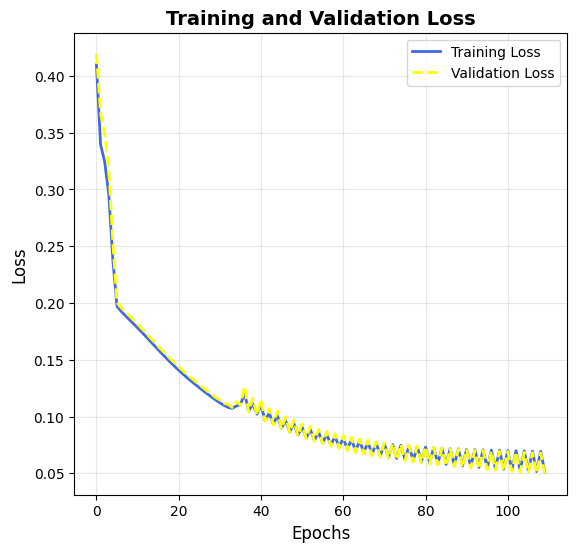

In [8]:
# Step 5: Visualize Loss and Accuracy
plt.figure(figsize=(14, 6))

# Subplot 1: Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training Loss", linestyle='-', color='royalblue', linewidth=2)
plt.plot(val_losses, label="Validation Loss", linestyle='--', color='yellow', linewidth=2)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Training and Validation Loss", fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(alpha=0.3)


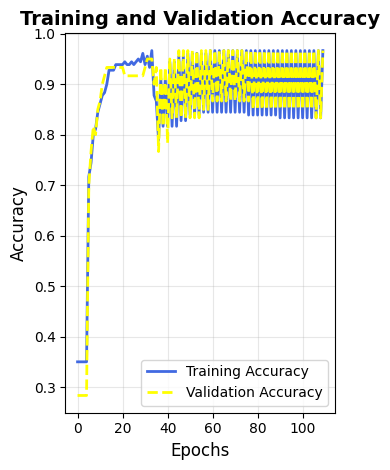

In [9]:
# Subplot 2: Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Training Accuracy", linestyle='-', color='royalblue', linewidth=2)
plt.plot(val_accuracies, label="Validation Accuracy", linestyle='--', color='yellow', linewidth=2)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Training and Validation Accuracy", fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [10]:
# Step 6: Evaluate the Model
test_output = nn.feed_forward(X_test)
predicted_classes = np.argmax(test_output, axis=1)
actual_classes = np.argmax(y_test, axis=1)

test_accuracy = accuracy_score(actual_classes, predicted_classes)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Test Accuracy: 98.33%


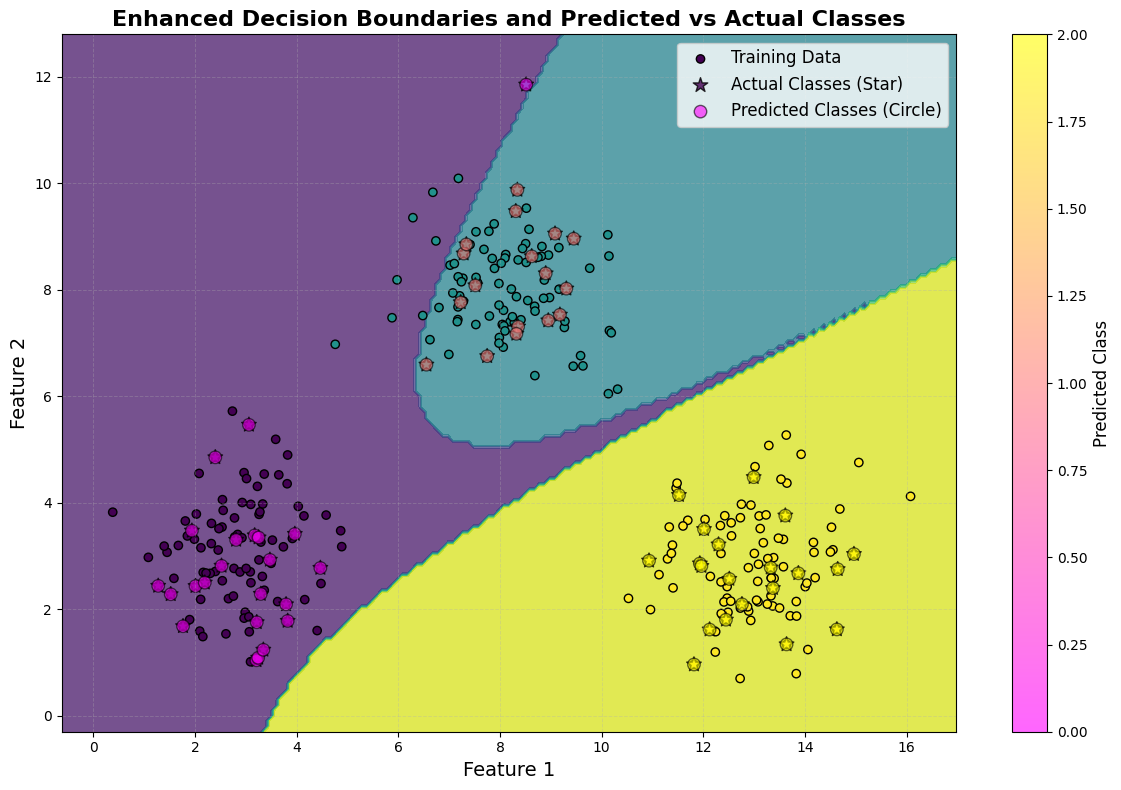

In [14]:
# Step 7: Genearate the graph
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

Z = nn.feed_forward(np.c_[xx.ravel(), yy.ravel()])
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(12, 8))

plt.contourf(xx, yy, Z, alpha=0.75, cmap="viridis")

plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis", edgecolor="k", label="Training Data")

scatter_actual = plt.scatter(
    X_test[:, 0], X_test[:, 1],
    c=actual_classes, cmap="viridis",
    marker="*", s=120, edgecolors="black", alpha=0.8,
    label="Actual Classes (Star)"
)

scatter_predicted = plt.scatter(
    X_test[:, 0], X_test[:, 1],
    c=predicted_classes, cmap="spring",
    marker="o", s=80, edgecolors="black", alpha=0.6,
    label="Predicted Classes (Circle)"
)

plt.title("Enhanced Decision Boundaries and Predicted vs Actual Classes", fontsize=16, fontweight='bold')
plt.xlabel("Feature 1", fontsize=14)
plt.ylabel("Feature 2", fontsize=14)

plt.grid(alpha=0.3, linestyle='--', linewidth=0.7)
plt.legend(fontsize=12, loc="upper right", frameon=True)

cbar = plt.colorbar(scatter_predicted, ax=plt.gca(), orientation='vertical')
cbar.set_label('Predicted Class', fontsize=12)
cbar.ax.tick_params(labelsize=10)

plt.tight_layout()
plt.show()

